# Imports and parameters

In [1]:
import os
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib.colors import SymLogNorm

from PerseusGammaCalibration import perseus_model_library
from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
#----- SZ data
dat_dir     = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file   = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
FWHM_planck = 10.0*u.arcmin
ymap_SM     = 1*u.arcmin
yprof_reso  = 5*u.arcmin
ymap_fov    = 6*u.deg
ymap_reso   = 2.5*u.arcmin

#----- X data
xmap_file      = dat_dir+'/ROSAT/RASS_1_2048.fits'
xmap_sp_file   = dat_dir+'/ROSAT/spectrum.sp'
xmap_resp_file = dat_dir+'/ROSAT/pspcb_gain1_256.rsp'
xmap_nh_file   = dat_dir+'/ROSAT/HI_LAB_II_1_256_nh.fits'
xmap_band      = [0.1*u.keV, 2.4*u.keV]
FWHM_rass      = 1.8*u.arcmin
xmap_SM        = 1*u.arcmin
xprof_reso     = 1*u.arcmin
xmap_fov       = 6*u.deg
xmap_reso      = 0.5*u.arcmin
xmap_coeff     = 5.24559/(hp.nside2resol(2048, arcmin=True)**2)

#----- Various
NFWHMmask = 3
NR500ZL = 3
src1 = SkyCoord("3h19m48.16s +41d30m42s", frame='icrs')              # NGC1275
src2 = SkyCoord(48.25948051*u.deg, +41.35073379*u.deg, frame='icrs') # as the peak of the map
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

### Common parameters

In [3]:
Cbase = perseus_model_library.default_model()

<Quantity 13.70432859 kpc>

In [4]:
kpcperarcmin = Cbase.cosmo.kpc_proper_per_arcmin(Cbase.redshift)

### Cosmological correction

In [5]:
cor_ett1999 = 50.0/Cbase.cosmo.H0.to_value('km s-1 Mpc-1')
cor_chu2003 = 50.0/Cbase.cosmo.H0.to_value('km s-1 Mpc-1')
cor_urb2014 = 70.0/Cbase.cosmo.H0.to_value('km s-1 Mpc-1')
rescal_urb2014 = 0.9
cor_ett1999, cor_chu2003, cor_urb2014

(0.7142857142857143, 0.7142857142857143, 1.0)

### Churazov et al. (2003) n and T

In [6]:
C1 = copy.deepcopy(Cbase)
C1.name='Churazov_Nall_Tall'

C1.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*cor_chu2003))**3)/(2.3+(radius.to_value('kpc')/(100.0*cor_chu2003))**3)*u.keV
radius, n_e = C1.get_density_gas_profile(radius)
P_e = n_e*T_e
C1.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Churazov et al. (2003) n core + Urban et al. (2014) n out and P

In [7]:
#---------- Cluster definition
C2 = copy.deepcopy(Cbase)
C2.name='Churazov_Nin_Urban_Nout_Pout'

#---------- Merge Churazov and Urban density profiles
# --> Same as base model

#---------- Set the pressure
ctmp = copy.deepcopy(C2)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
pgasmod = ctmp.pressure_gas_model
del pgasmod['c500']
C2.pressure_gas_model = pgasmod

### Churazov et al. (2003) n core + Ettori et al. (1999) n out + Urban et al. (2014) P

In [8]:
#---------- Cluster definition
C3 = copy.deepcopy(Cbase)
C3.name='Churazov_Nin_Ettori_Nout_Urban_Pout'

#---------- Merge Churazov and Urban density profiles
theta_ref = 20*u.arcmin
# Total Churazov 2003 density
C3.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref1 = C3.get_density_gas_profile(theta_ref*kpcperarcmin)
# Outskirt Churazov 2003 density
C3.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chu2003, 'n_0':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref2 = C3.get_density_gas_profile(theta_ref*kpcperarcmin)
# Ettori 1999 normalized density
C3.density_gas_model = {'name':'beta', 'beta':0.81, 'r_c':17.0*u.arcmin*kpcperarcmin, 'n_0':1*u.cm**-3*cor_ett1999**-0.5}
bid, nref3 = C3.get_density_gas_profile(theta_ref*kpcperarcmin)
# Merge the two unsuring consistency
C3.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.81, 'r_c2':17*u.arcmin*kpcperarcmin, 'n_02':(nref2/nref3).to_value('')*1*u.cm**-3*cor_ett1999**-0.5}
bid, nref4 = C3.get_density_gas_profile(theta_ref*kpcperarcmin)

#---------- Set the pressure
ctmp = copy.deepcopy(C3)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
pgasmod = ctmp.pressure_gas_model
del pgasmod['c500']
C3.pressure_gas_model = pgasmod

### Churazov et al. (2003) n core + Urban et al. (2014) n & T outskirt

In [9]:
C4 = copy.deepcopy(Cbase)
C4.name='Churazov_Nin_Urban_Nout_Tout'

#---------- Merge Churazov and Urban density profiles
# --> Same as base model

#---------- Urban temperature profile
radius = np.logspace(0,5,1000)*u.kpc
T_e = 4.06*u.keV*((radius.to_value('kpc')/(294*cor_urb2014))**6.72+0.72)/(1+(radius.to_value('kpc')/(294*cor_urb2014))**6.72)*((radius.to_value('Mpc')/(1.6*cor_urb2014))**-0.33)/(1+(radius.to_value('Mpc')/(1.6*cor_urb2014))**16.24)**(2.36/16.24)
n_e = C4.get_density_gas_profile(radius)[1]
P_e = n_e*T_e
C4.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Churazov et al. (2003) n & T core + Urban et al. (2014) n & T outskirt

In [10]:
C5 = copy.deepcopy(Cbase)
C5.name='Churazov_Nin_Tin_Urban_Nout_Tout'

#---------- Merge Churazov and Urban density profiles
# --> Same as base model

#---------- Churazov+Urban temperature profile
# --> Same as base model

#### List models

In [11]:
Clist = [C1,C2,C3,C4,C5]

In [12]:
for C in Clist:
    print('--- '+C.name)
    print(C.density_gas_model)
    if C.pressure_gas_model['name'] != 'User': 
        print(C.pressure_gas_model)
    else:
        print('Temperature based model')

--- Churazov_Nall_Tall
{'name': 'doublebeta', 'n_01': <Quantity 0.04614542 1 / cm3>, 'r_c1': <Quantity 57.14285714 kpc>, 'beta1': 1.2, 'n_02': <Quantity 0.00479202 1 / cm3>, 'r_c2': <Quantity 200. kpc>, 'beta2': 0.58}
Temperature based model
--- Churazov_Nin_Urban_Nout_Pout
{'name': 'doublebeta', 'n_01': <Quantity 0.04614542 1 / cm3>, 'r_c1': <Quantity 57.14285714 kpc>, 'beta1': 1.2, 'n_02': <Quantity 0.0036 1 / cm3>, 'r_c2': <Quantity 277.88161667 kpc>, 'beta2': 0.71}
{'name': 'GNFW', 'P_0': <Quantity 0.01806918 keV / cm3>, 'c500': 1.81, 'r_p': <Quantity 695.40876915 kpc>, 'a': 1.33, 'b': 4.13, 'c': 0.31}
--- Churazov_Nin_Ettori_Nout_Urban_Pout
{'name': 'doublebeta', 'n_01': <Quantity 0.04614542 1 / cm3>, 'r_c1': <Quantity 57.14285714 kpc>, 'beta1': 1.2, 'n_02': <Quantity [0.00315235] 1 / cm3>, 'r_c2': <Quantity 358.42090162 kpc>, 'beta2': 0.81}
{'name': 'GNFW', 'P_0': <Quantity 0.01806918 keV / cm3>, 'c500': 1.81, 'r_p': <Quantity 695.40876915 kpc>, 'a': 1.33, 'b': 4.13, 'c': 0.31}
-

# Model to model comparison

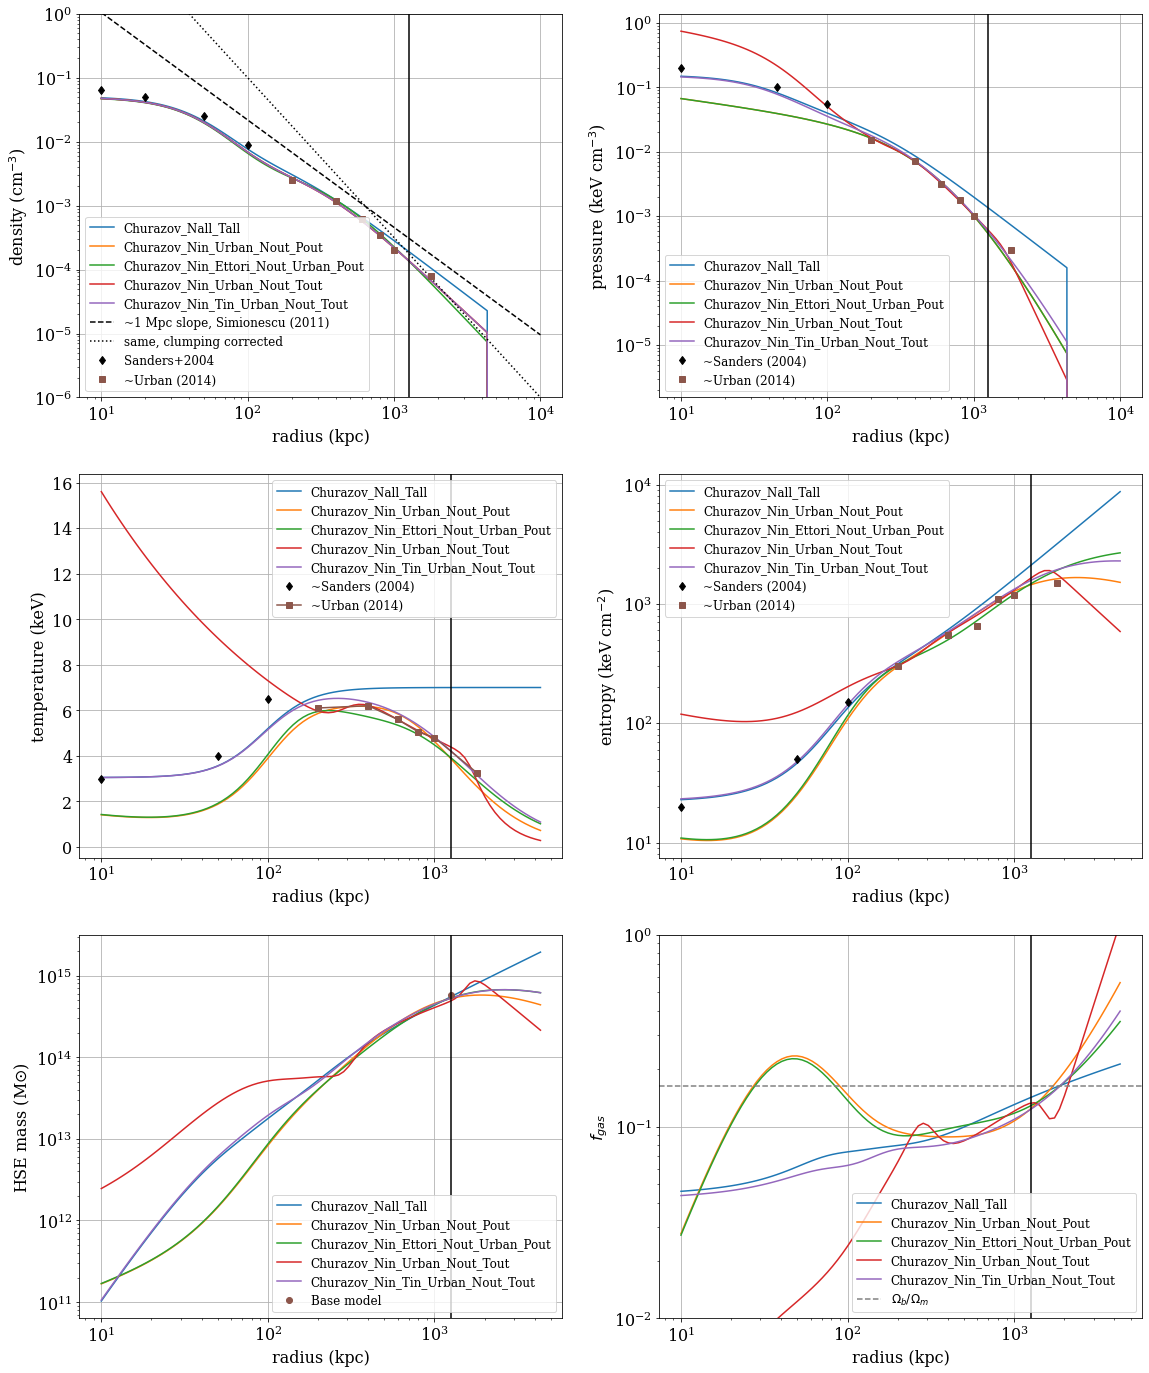

In [13]:
r = np.logspace(1,4,100)*u.kpc

fig = plt.figure(0, figsize=(18, 24))
ax = plt.subplot(321)
for C in Clist:
    r,n = C.get_density_gas_profile(r)
    plt.loglog(r,n, label=C.name)
plt.loglog(r, 50*r**-1.68, linestyle='--', color='k', label='~1 Mpc slope, Simionescu (2011)')
plt.loglog(r, 10000*r**-2.50, linestyle=':', color='k', label='same, clumping corrected')
plt.loglog([10,20,50,100], [0.065,0.05,0.025,0.009], marker='d', linestyle='', color='k', label='Sanders+2004')
plt.plot([200,400,600,800,1000,1800], [0.0025,0.0012,0.00062,0.00035,0.0002,0.00008], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm$^{-3}$)')
plt.ylim(1e-6,1e0)
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(322)
for C in Clist:
    r,p = C.get_pressure_gas_profile(r)
    plt.loglog(r,p, label=C.name)
plt.loglog([10,45,100], [0.2,0.1,0.055], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [0.015,0.0072,0.0032,0.0018,0.001,0.0003], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('pressure (keV cm$^{-3}$)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(323)
for C in Clist:
    r,t = C.get_temperature_gas_profile(r)
    plt.plot(r,t, label=C.name)
plt.plot([10,50,100], [3,4,6.5], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [6.1,6.2,5.6,5.05,4.8,3.25], marker='s', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('temperature (keV)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(324)
for C in Clist:
    r,k = C.get_entropy_gas_profile(r)
    plt.loglog(r,k, label=C.name)
plt.loglog([10,50,100], [20,50,150], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [300,550,650,1100,1200,1500], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(325)
for C in Clist:
    r,m = C.get_hse_mass_profile(r)
    plt.loglog(r,m, label=C.name)
plt.plot([C1.R500.to_value('kpc')], [C1.M500.to_value('Msun')], marker='o', linestyle='', label='Base model')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('HSE mass (M$\odot$)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(326)
for C in Clist:
    r,f = C.get_fgas_profile(r)
    plt.loglog(r,f, label=C.name)
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.axhline(Cbase.cosmo.Ob0/Cbase.cosmo.Om0, color='grey', linestyle='--', label=r'$\Omega_b / \Omega_m$')
plt.xlabel('radius (kpc)')
plt.ylabel('$f_{gas}$')
plt.ylim(1e-2,1)
plt.legend(fontsize=12)
plt.grid()

In [40]:
# Density
fig = plt.figure(0, figsize=(8, 6))
r,n = C5.get_density_gas_profile(r)
plt.loglog(r,n, linewidth=6, label='This work', color='green')
r,n = C1.get_density_gas_profile(r)
plt.loglog(r,n, linewidth=2, label='Churazov et al. (2003)', color='blue')
r,n = C3.get_density_gas_profile(r)
plt.loglog(r,n, linewidth=2, label='Churazov et al. (2003) + Ettori et al. (1999)', color='orange')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xlabel('radius (kpc)')
plt.ylabel('electron density (cm$^{-3}$)')
plt.ylim(1e-5,1e-1)
plt.xlim(10,5000)
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_density_model.pdf')
plt.close()

# Temperature
fig = plt.figure(1, figsize=(8, 6))
r,t = C5.get_temperature_gas_profile(r)
plt.plot(r,t, linewidth=6, label='This work', color='green')
r,t = C1.get_temperature_gas_profile(r)
plt.plot(r,t, linewidth=2, label='Churazov et al. (2003)', color='blue')
r,t = C4.get_temperature_gas_profile(r)
plt.plot(r,t, linewidth=2, label='Urban et al. (2014)', color='orange')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xscale('log')
plt.ylim(0,8)
plt.xlim(10,5000)
plt.xlabel('radius (kpc)')
plt.ylabel('gas temperature (keV)')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_temperature_model.pdf')
plt.close()

# Pressure
fig = plt.figure(3, figsize=(8, 6))
r,p = C5.get_pressure_gas_profile(r)
plt.loglog(r, p, linewidth=6, label='This work', color='green')
r,p = C1.get_pressure_gas_profile(r)
plt.loglog(r, p, linewidth=2,label='Churazov et al. (2003)', color='blue')
r,p = C2.get_pressure_gas_profile(r)
plt.loglog(r, p, linewidth=2,label='Urban et al. (2014), UPP fit', color='orange', linestyle=':')
r,p = C4.get_pressure_gas_profile(r)
plt.loglog(r, p, linewidth=2,label='Urban et al. (2014), $n_e \\times k_{B}T$ models', color='orange')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xlim(10,5000)
plt.xlabel('radius (kpc)')
plt.ylabel('electron pressure (keV cm$^{-3}$)')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_pressure_model.pdf')
plt.close()

# Entropy
fig = plt.figure(3, figsize=(8, 6))
r,k = C1.get_entropy_gas_profile(r)
plt.loglog(r,k, linewidth=3, label='Churazov et al. (2003)', color='blue')
r,k = C5.get_entropy_gas_profile(r)
plt.loglog(r,k, linewidth=3, label='This work', color='green')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xlim(10,5000)
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_entropy_model.pdf')
plt.close()

# mass
fig = plt.figure(3, figsize=(8, 6))
r,m = C1.get_hse_mass_profile(r)
plt.loglog(r,m, linewidth=3, label='Churazov et al. (2003)', color='blue')
r,m = C5.get_hse_mass_profile(r)
plt.loglog(r,m, linewidth=3, label='This work', color='green')
plt.plot([C1.R500.to_value('kpc')], [C1.M500.to_value('Msun')], marker='D', linestyle='', label=r'Baseline M$_{500, {\rm tot}}$', color='grey')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xlim(10,5000)
plt.xlabel('radius (kpc)')
plt.ylabel(r'HSE mass (M$_{\odot}$)')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_mhse_model.pdf')
plt.close()

# fgas
fig = plt.figure(3, figsize=(8, 6))
r,f = C1.get_fgas_profile(r)
plt.loglog(r,f, linewidth=3, label='Churazov et al. (2003)', color='blue')
r,f = C5.get_fgas_profile(r)
plt.loglog(r,f, linewidth=3, label='This work', color='green')
plt.axhline(Cbase.cosmo.Ob0/Cbase.cosmo.Om0, color='grey', linestyle='--', label=r'$\Omega_b / \Omega_m$')
plt.axvline(C1.R500.to_value('kpc'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.xlim(10,5000)
plt.ylim(3e-2,4e-1)
plt.ylabel('$f_{gas}$')
plt.xlabel('radius (kpc)')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Gas_fgas_model.pdf')
plt.close()

In [15]:
print('----- Uth500 -----')
for C in Clist:
    print(C.name+': '+str(C.get_thermal_energy_profile(radius=C.R500)[1][0]))

print('----- Uth(Rtrunc) -----')
for C in Clist:
    print(C.name+': '+str(C.get_thermal_energy_profile(radius=C.R_truncation)[1][0]))

----- Uth500 -----
Churazov_Nall_Tall: 3.182361102824274e+63 erg
Churazov_Nin_Urban_Nout_Pout: 1.9912749147619087e+63 erg
Churazov_Nin_Ettori_Nout_Urban_Pout: 1.9912749147619087e+63 erg
Churazov_Nin_Urban_Nout_Tout: 2.05635689807703e+63 erg
Churazov_Nin_Tin_Urban_Nout_Tout: 2.076892728436004e+63 erg
----- Uth(Rtrunc) -----
Churazov_Nall_Tall: 1.6209537049159665e+64 erg
Churazov_Nin_Urban_Nout_Pout: 3.906213479093699e+63 erg
Churazov_Nin_Ettori_Nout_Urban_Pout: 3.906213479093699e+63 erg
Churazov_Nin_Urban_Nout_Tout: 3.6486714518609084e+63 erg
Churazov_Nin_Tin_Urban_Nout_Tout: 4.391359927842703e+63 erg


In [16]:
for C in Clist:
    C.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, Tmin=0.1*u.keV, Tmax=15.0*u.keV, nbin=10,file_HI=xmap_nh_file, visu_nH=False, model='APEC',resp_file=xmap_resp_file, data_file=xmap_sp_file, app_nH_model=False)
    print('within R500: '+C.name+': '+str((C.get_xray_flux(Rmax=C.R500, type_integral='cylindrical', output_type='S', Cframe=True)*(4*np.pi*C.D_lum**2)).to('erg s-1')))
    print('within Rtrunc: '+C.name+': '+str((C.get_xray_flux(Rmax=C.R_truncation, type_integral='cylindrical', output_type='S', Cframe=True)*(4*np.pi*C.D_lum**2)).to('erg s-1')))
print('MCXC:', 6.21735)

within R500: Churazov_Nall_Tall: 8.72750831229712e+44 erg / s
within Rtrunc: Churazov_Nall_Tall: 1.021191468453284e+45 erg / s
within R500: Churazov_Nin_Urban_Nout_Pout: 7.17640574724822e+44 erg / s
within Rtrunc: Churazov_Nin_Urban_Nout_Pout: 7.793484003510789e+44 erg / s
within R500: Churazov_Nin_Ettori_Nout_Urban_Pout: 7.424642113712287e+44 erg / s
within Rtrunc: Churazov_Nin_Ettori_Nout_Urban_Pout: 7.848214514654753e+44 erg / s
within R500: Churazov_Nin_Urban_Nout_Tout: 6.739690951453083e+44 erg / s
within Rtrunc: Churazov_Nin_Urban_Nout_Tout: 7.384347058939649e+44 erg / s
within R500: Churazov_Nin_Tin_Urban_Nout_Tout: 6.9606012716746044e+44 erg / s
within Rtrunc: Churazov_Nin_Tin_Urban_Nout_Tout: 7.532533296114524e+44 erg / s
MCXC: 6.21735


# Comparison to Planck

### Get the data

In [17]:
ymap_data, yheader = map_tools.roi_extract_healpix(ymap_file, Cbase.coord.ra.value, Cbase.coord.dec.value, 
                                                  ymap_reso.to_value('deg'), [ymap_fov.to_value('deg'), ymap_fov.to_value('deg')],
                                                  visu=False)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [18]:
# Compute the rms
ymap_err = ymap_data*0 + np.std(ymap_data)
for i in [1,2,3,4,5]: 
    ymap_err = ymap_data*0 + np.std(ymap_data[np.abs(ymap_data/ymap_err) < 3])    
mask = ymap_err*0+1

# Mask central source
ramap, decmap = map_tools.get_radec_map(yheader)
distance = map_tools.greatcircle(ramap, decmap, src1.ra.to_value('deg'), src1.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0
    
# Secondary
distance = map_tools.greatcircle(ramap, decmap, src2.ra.to_value('deg'), src2.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0

print('Median rms = '+str(np.nanmedian(ymap_err.data)))

Median rms = 2.6763263103088956e-06


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Zero level correction: -8.656435284137842e-07


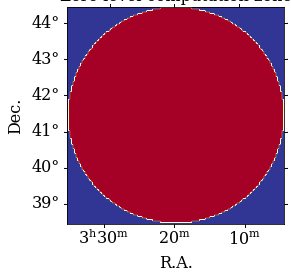

In [19]:
# Correct for the local background
ramap, decmap = map_tools.get_radec_map(yheader)
distance = map_tools.greatcircle(ramap, decmap, Cbase.coord.ra.to_value('deg'), Cbase.coord.dec.to_value('deg'))
wzl = (distance > NR500ZL*C1.theta500.to_value('deg'))
zlmask = distance*0
zlmask[wzl] = 1
ZL = np.median(ymap_data[wzl])

# Show the map
fig = plt.figure(0)
ax = plt.subplot(111, projection=WCS(yheader))
plt.imshow(zlmask, origin='lower', cmap='RdYlBu')
plt.title('Zero level computation zone')
plt.xlabel('R.A.')
plt.ylabel('Dec.')

# Correction
ymap_data = ymap_data - ZL
print('Zero level correction: '+str(ZL))

### Get the model

In [20]:
for C in Clist:
    C.map_fov = ymap_fov
    C.map_reso = ymap_reso
    C.map_header = yheader

In [21]:
ymap_models = []
for C in Clist:
    ymap_model_im = C.get_sz_map(Compton_only=True)
    ymap_model_im = ndimage.gaussian_filter(ymap_model_im, sigma=FWHM2sigma*(FWHM_planck/ymap_reso).to_value(''), order=0)
    ymap_models.append(ymap_model_im)

### Profile

In [22]:
yprof_rad, yprof_data, yprof_err = map_tools.radial_profile_sb(ymap_data,
                                                               (Cbase.coord.ra.to_value('deg'), 
                                                                Cbase.coord.dec.to_value('deg')), 
                                                               stddev=ymap_err,
                                                               header=yheader,binsize=yprof_reso.to_value('deg'))

yprof_models = []
for im in range(len(Clist)):
    yprof_model_im = map_tools.radial_profile_sb(ymap_models[im], (Cbase.coord.ra.to_value('deg'), Cbase.coord.dec.to_value('deg')), stddev=ymap_models[im]*0+1, header=yheader, binsize=yprof_reso.to_value('deg'))[1]
    yprof_models.append(yprof_model_im)

### Comparison

In [23]:
ymap_data   = ndimage.gaussian_filter(ymap_data, sigma=FWHM2sigma*(ymap_SM/xmap_reso).to_value(''), order=0)
for Y in ymap_models:
    Y = ndimage.gaussian_filter(Y, sigma=FWHM2sigma*(ymap_SM/xmap_reso).to_value(''), order=0)

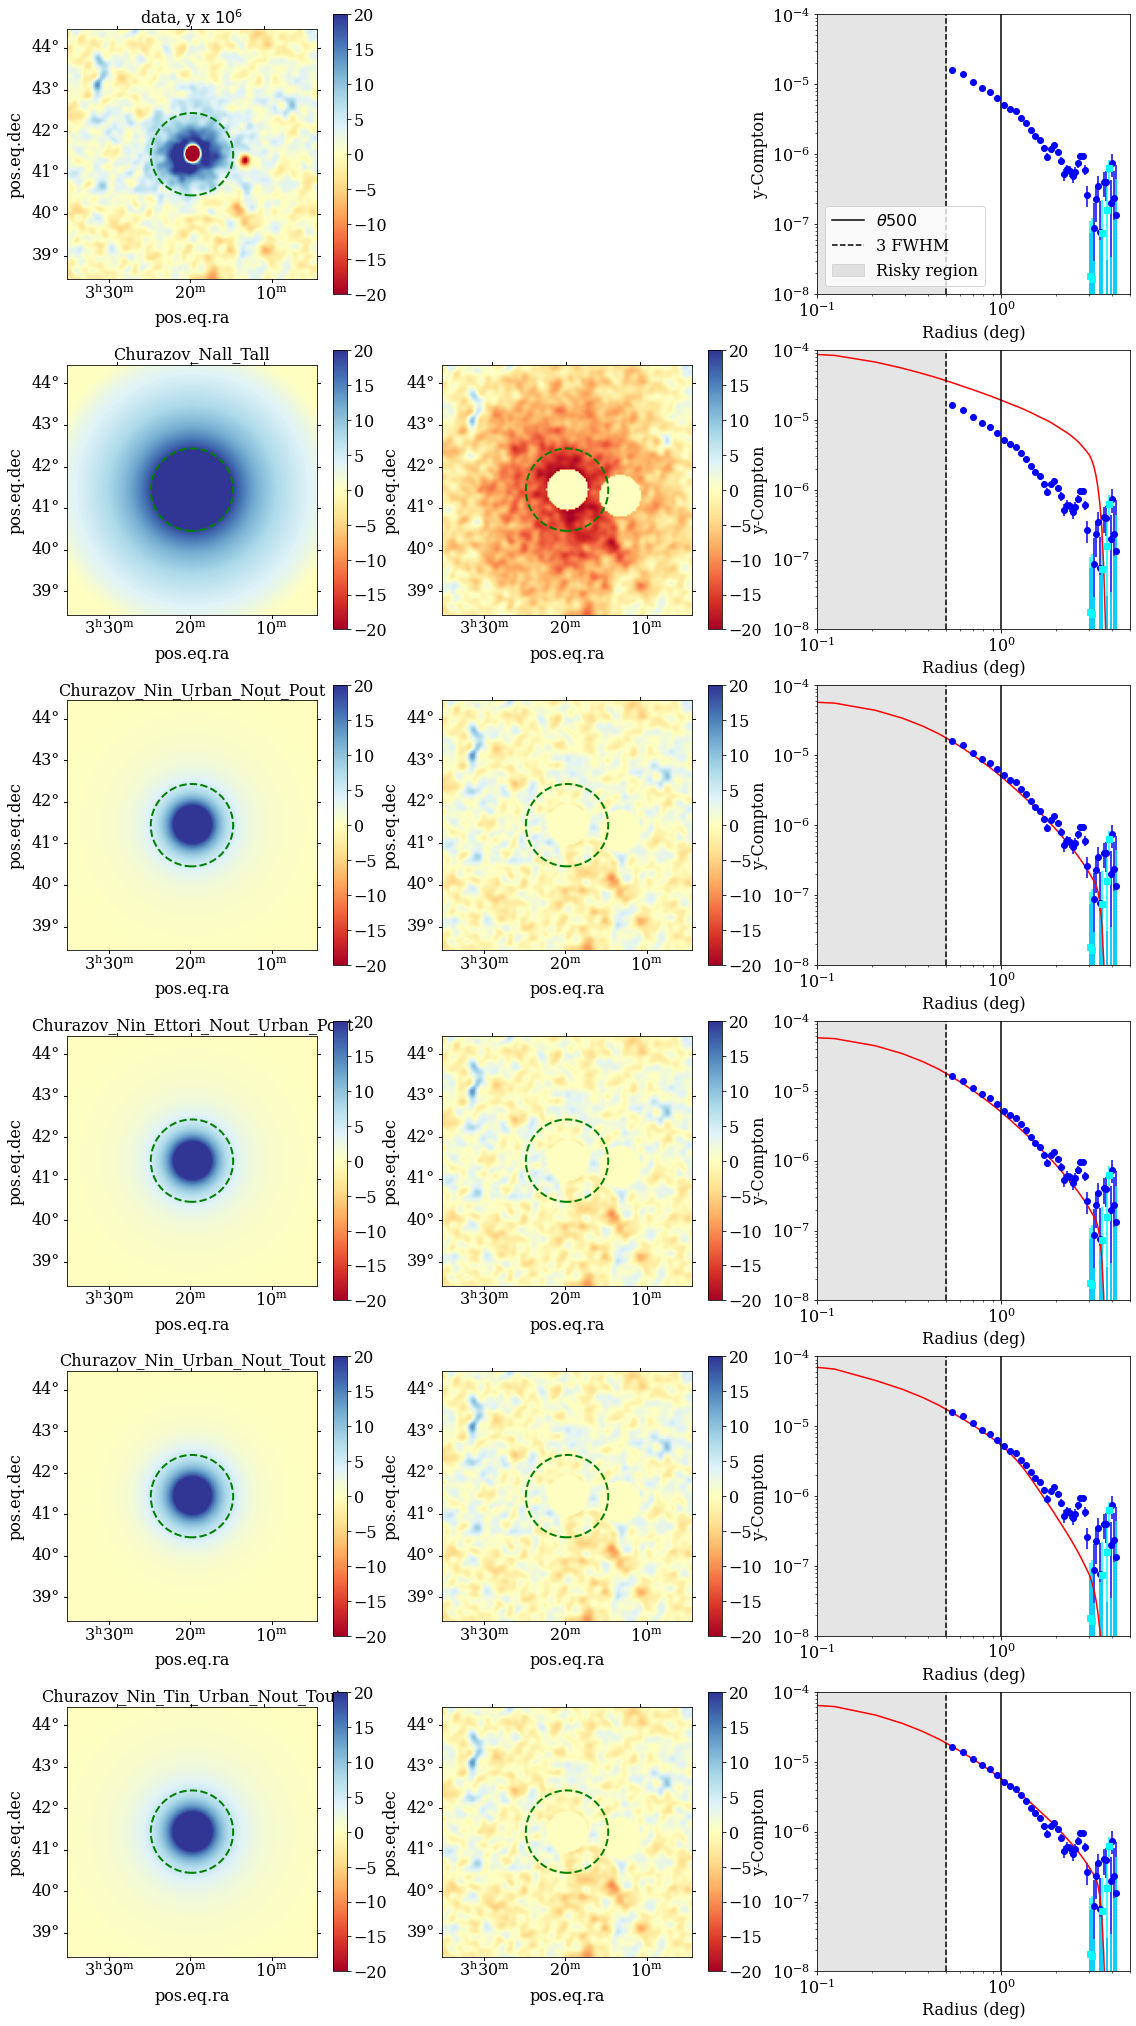

In [24]:
Ncol = 1+len(Clist)

fig = plt.figure(0, figsize=(18, Ncol*6))
#----- Data
ax = plt.subplot(Ncol, 3, 1, projection=WCS(yheader))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*C1.theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*C1.theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title('data, y x $10^6$')

ax = plt.subplot(Ncol, 3, 3)
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
plt.axvline(C1.theta500.to_value('deg'), color='k', label='$\\theta500$')
plt.axvline(NFWHMmask*FWHM_planck.to_value('deg'), color='k', linestyle='--', label=str(NFWHMmask)+' FWHM')
plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
plt.ylim(1e-8,1e-4)
plt.xlim(1e-1,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('y-Compton')
plt.legend()

#----- Models
im = 4
for imod in range(len(Clist)):
    ax = plt.subplot(Ncol,3,im, projection=WCS(yheader))
    plt.imshow(1e6*(ymap_models[imod]), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
    circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()
    plt.title(Clist[imod].name)

    ax = plt.subplot(Ncol,3,im+1, projection=WCS(yheader))
    plt.imshow(1e6*mask*(ymap_data-ymap_models[imod]), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
    circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()

    ax = plt.subplot(Ncol, 3, im+2)
    plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
    plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
    plt.plot(yprof_rad, yprof_models[imod], marker='', linestyle='-', color='red')
    plt.axvline(Clist[imod].theta500.to_value('deg'), color='k')
    plt.axvline(NFWHMmask*FWHM_planck.to_value('deg'), color='k', linestyle='--')
    plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
    plt.ylim(1e-8,1e-4)
    plt.xlim(1e-1,5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (deg)')
    plt.ylabel('y-Compton')
    
    im = im + 3

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


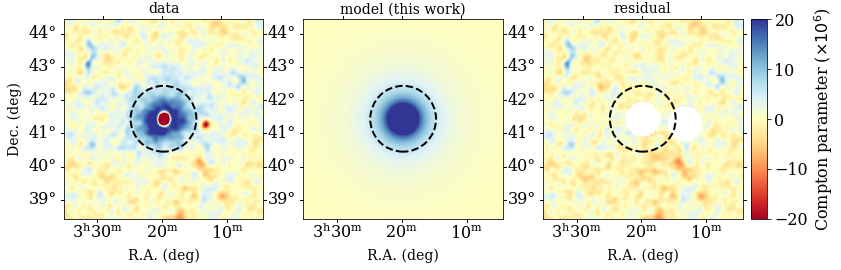

In [25]:
fig = plt.figure(0, figsize=(11.5, 5))
ax = plt.subplot(1, 3, 1, projection=WCS(yheader))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*C1.theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*C1.theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='k', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.title('data', fontsize=14)
plt.ylabel('Dec. (deg)', fontsize=14)
plt.xlabel('R.A. (deg)', fontsize=14)

ax = plt.subplot(1, 3, 2, projection=WCS(yheader))
plt.imshow(1e6*ymap_models[4], vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*C1.theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*C1.theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='k', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.title('model (this work)', fontsize=14)
plt.xlabel('R.A. (deg)', fontsize=14)
plt.ylabel(' ', fontsize=14)

mask2 = mask
mask2[mask == 0] = np.nan
ax = plt.subplot(1, 3, 3, projection=WCS(yheader))
plt.imshow(1e6*mask2*(ymap_data-ymap_models[4]), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*C1.theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*C1.theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='k', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.title('residual', fontsize=14)
plt.xlabel('R.A. (deg)', fontsize=14)
plt.ylabel(' ', fontsize=14)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.set_label('Compton parameter ($\\times 10^6$)')

fig.savefig(outdir+'/Planck_map_comparison.pdf', bbox_inches='tight', tight_layout=True)

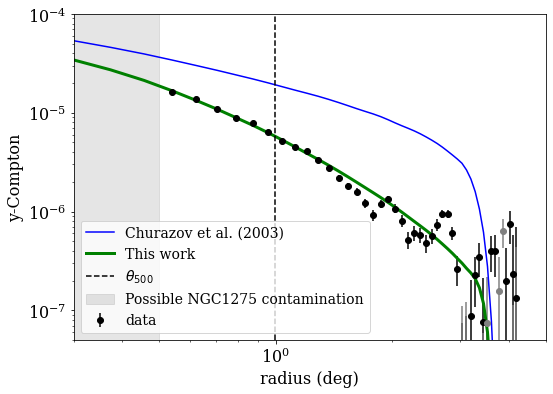

In [26]:
fig = plt.figure(0, figsize=(8, 6))
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='k', label='data')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='o', linestyle='', color='grey')
plt.plot(yprof_rad, yprof_models[0], marker='', linestyle='-', color='blue', label='Churazov et al. (2003)')
plt.plot(yprof_rad, yprof_models[4], marker='', linestyle='-', linewidth=3, color='green', label='This work')
plt.axvline(C1.theta500.to_value('deg'), color='k', linestyle='--', label=r'$\theta_{500}$')
plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Possible NGC1275 contamination')
plt.ylim(5e-8,1e-4)
plt.xlim(3e-1,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (deg)')
plt.ylabel('y-Compton')
plt.legend(fontsize=14)
plt.savefig(outdir+'/Planck_profile_comparison.pdf')

# Comparison to RASS

### Get the data

In [27]:
xmap_data, header = map_tools.roi_extract_healpix(xmap_file, Cbase.coord.ra.value, Cbase.coord.dec.value, xmap_reso.to_value('deg'), [xmap_fov.to_value('deg'), xmap_fov.to_value('deg')],visu=False)
xmap_data = xmap_data*xmap_coeff*(1*u.arcmin**-2).to_value('deg-2')

In [28]:
# Compute the rms
xmap_err = xmap_data*0 + np.std(xmap_data)
for i in [1,2,3,4,5]: 
    xmap_err = xmap_data*0 + np.std(xmap_data[np.abs(xmap_data/xmap_err) < 3])    
print('Median rms = '+str(np.nanmedian(xmap_err.data)))

Median rms = 1.4080583874182822


Zero level correction: 2.224275421191348


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


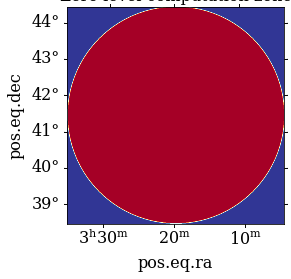

In [29]:
# Correct for the local background
ramap, decmap = map_tools.get_radec_map(header)
distance = map_tools.greatcircle(ramap, decmap, Cbase.coord.ra.to_value('deg'), Cbase.coord.dec.to_value('deg'))
wzl = (distance > NR500ZL*C1.theta500.to_value('deg'))
zlmask = distance*0
zlmask[wzl] = 1
ZL = np.median(xmap_data[wzl])

# Show the map
fig = plt.figure(0, figsize=(5, 4))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(zlmask, origin='lower', cmap='RdYlBu')
plt.title('Zero level computation zone')

# Correction
if ~np.isnan(ZL):
    xmap_data = xmap_data - ZL
print('Zero level correction: '+str(ZL))

### Get the model

In [30]:
for C in Clist:
    C.map_fov = xmap_fov
    C.map_reso = xmap_reso
    C.map_header = header

In [31]:
xmap_models = []
for C in Clist:
    C.make_xspec_table(Emin=xmap_band[0], Emax=xmap_band[1], Tmin=0.1*u.keV, Tmax=15.0*u.keV, nbin=10,file_HI=xmap_nh_file, visu_nH=False, model='APEC',resp_file=xmap_resp_file, data_file=xmap_sp_file, app_nH_model=False)
    xmap_model_im = C.get_xray_map(output_type='R').to_value('s-1 deg-2')
    xmap_model_im = ndimage.gaussian_filter(xmap_model_im, sigma=FWHM2sigma*(FWHM_rass/xmap_reso).to_value(''), order=0)
    xmap_models.append(xmap_model_im)

### Profile

In [32]:
xprof_rad, xprof_data, xprof_err = map_tools.radial_profile_sb(xmap_data, (Cbase.coord.ra.to_value('deg'), Cbase.coord.dec.to_value('deg')), stddev=xmap_err, header=header,binsize=xprof_reso.to_value('deg'))

xprof_models = []
for im in range(len(Clist)):
    xprof_model_im = map_tools.radial_profile_sb(xmap_models[im], (Cbase.coord.ra.to_value('deg'), Cbase.coord.dec.to_value('deg')), stddev=xmap_models[im]*0+1, header=header, binsize=xprof_reso.to_value('deg'))[1]
    xprof_models.append(xprof_model_im)

### Comparison

In [33]:
xmap_data   = ndimage.gaussian_filter(xmap_data, sigma=FWHM2sigma*(xmap_SM/xmap_reso).to_value(''), order=0)
for X in xmap_models:
    X = ndimage.gaussian_filter(X, sigma=FWHM2sigma*(xmap_SM/xmap_reso).to_value(''), order=0)

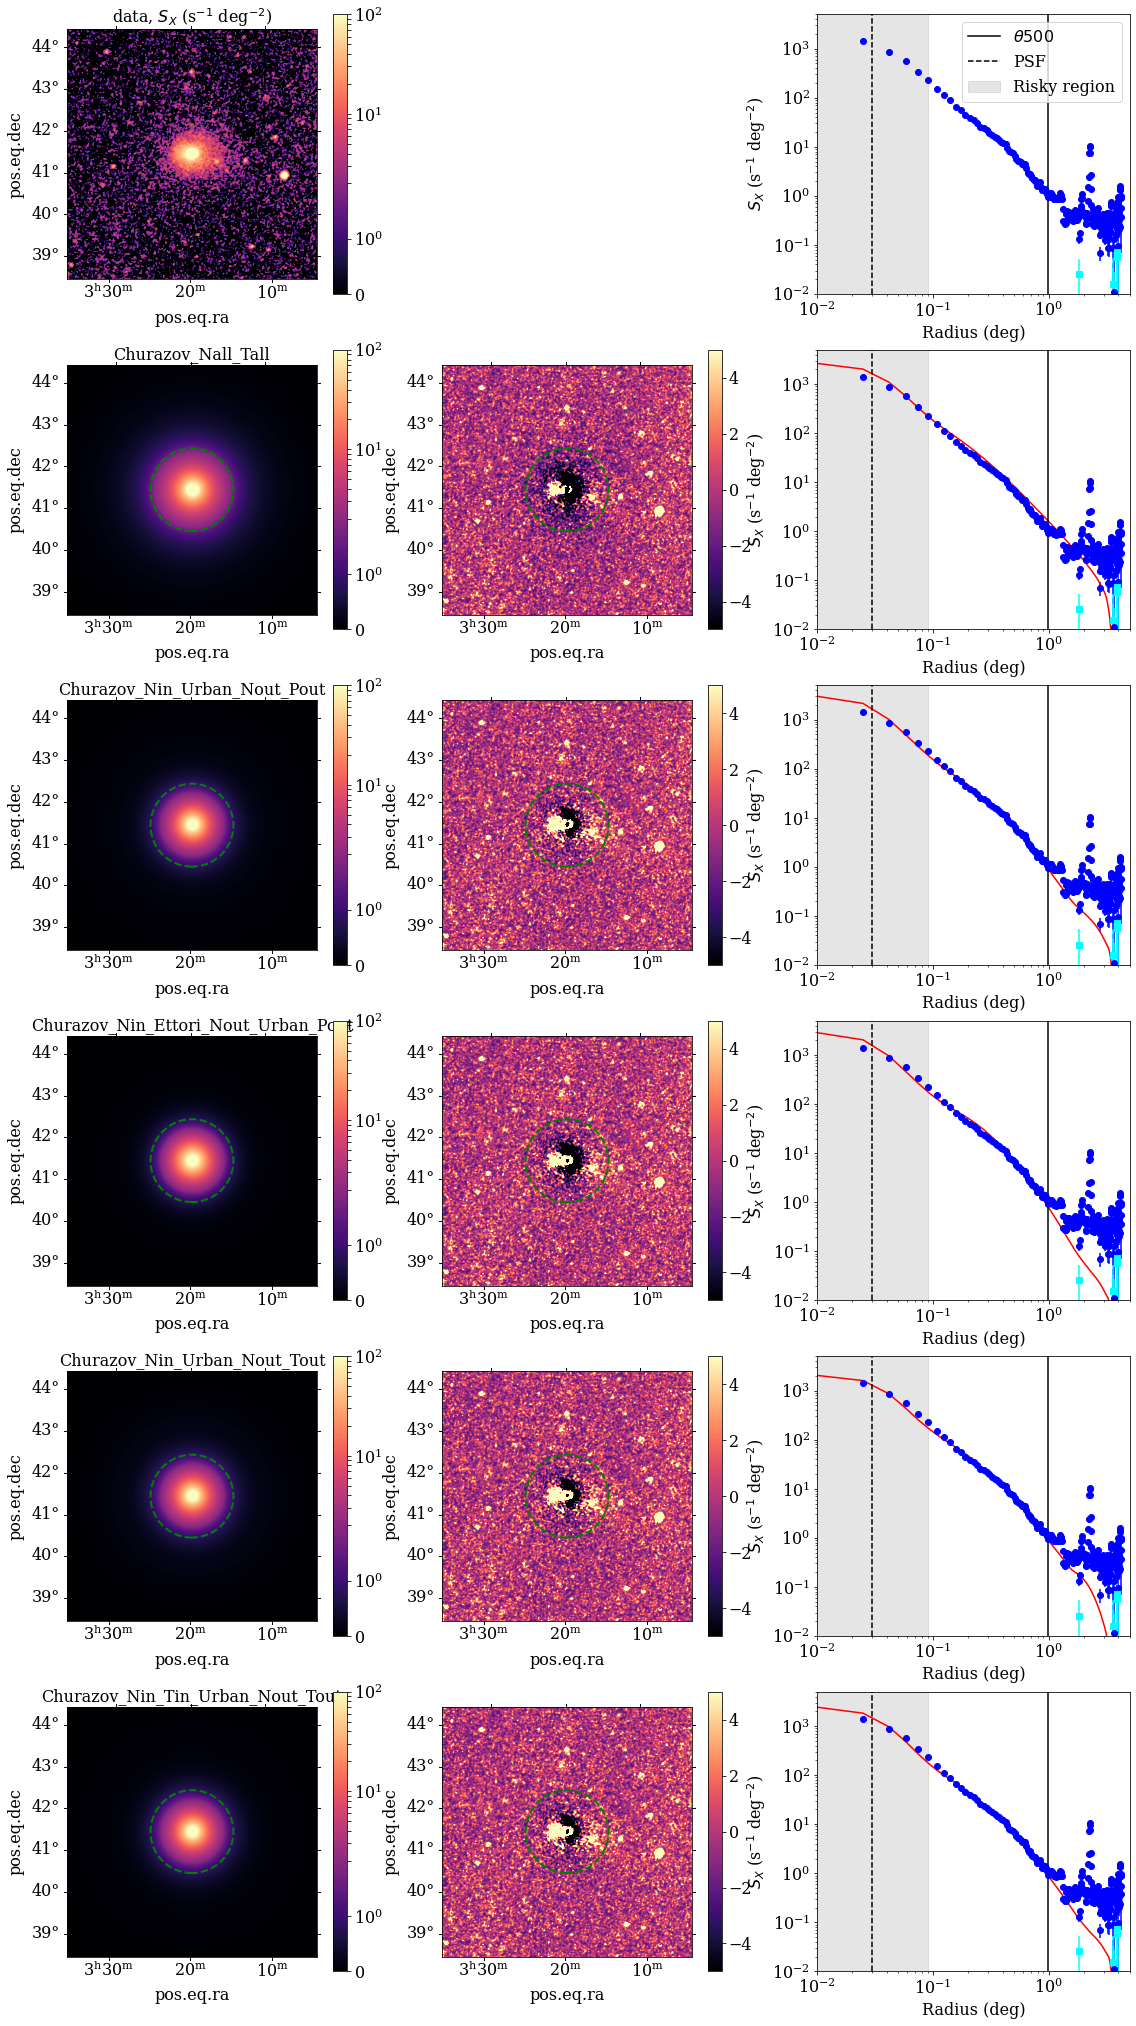

In [34]:
Ncol = 1+len(Clist)

norm = SymLogNorm(2e0, vmin=0, vmax=1e2, base=10)

fig = plt.figure(0, figsize=(18, Ncol*6))
#----- Data
ax = plt.subplot(Ncol, 3, 1, projection=WCS(header))
plt.imshow(xmap_data, origin='lower', cmap='magma', norm=norm)
plt.colorbar()
plt.title('data, $S_X$ (s$^{-1}$ deg$^{-2}$)')

ax = plt.subplot(Ncol, 3, 3)
plt.errorbar(xprof_rad, xprof_data, xprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(xprof_rad, -xprof_data, xprof_err, marker='s', linestyle='', color='cyan')
plt.axvline(C1.theta500.to_value('deg'), color='k', label='$\\theta500$')
plt.axvline(FWHM_rass.to_value('deg'), color='k', linestyle='--', label='PSF')
plt.fill_between([0,3*FWHM_rass.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
plt.ylim(1e-2,5e3)
plt.xlim(1e-2,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('$S_X$ (s$^{-1}$ deg$^{-2}$)')
plt.legend()

#----- Model 1
im = 4
for imod in range(len(Clist)):
    ax = plt.subplot(Ncol,3,im, projection=WCS(header))
    plt.imshow(xmap_models[imod], origin='lower', cmap='magma', norm=norm)
    circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()
    plt.title(Clist[imod].name)

    ax = plt.subplot(Ncol,3,im+1, projection=WCS(header))
    plt.imshow(xmap_data-xmap_models[imod], vmin=-5, vmax=5, origin='lower', cmap='magma')
    circle = matplotlib.patches.Ellipse((Cbase.coord.ra.value, Cbase.coord.dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Cbase.coord.dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()

    ax = plt.subplot(Ncol, 3, im+2)
    plt.errorbar(xprof_rad, xprof_data, xprof_err, marker='o', linestyle='', color='blue')
    plt.errorbar(xprof_rad, -xprof_data, xprof_err, marker='s', linestyle='', color='cyan')
    plt.plot(xprof_rad, xprof_models[imod], marker='', linestyle='-', color='red')
    plt.axvline(Clist[imod].theta500.to_value('deg'), color='k')
    plt.axvline(FWHM_rass.to_value('deg'), color='k', linestyle='--', label='PSF')
    plt.fill_between([0,3*FWHM_rass.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
    plt.ylim(1e-2,5e3)
    plt.xlim(1e-2,5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (deg)')
    plt.ylabel('$S_X$ (s$^{-1}$ deg$^{-2}$)')

    im = im + 3